In [1]:
import matplotlib.pyplot as plot
import scipy.stats as stats
import numpy
import math

light = "#DCBCBC"
light_highlight = "#C79999"
mid = "#B97C7C"
mid_highlight = "#A25050"
dark = "#8F2727"
dark_highlight = "#7C0000"
green = "#00FF00"

To facilitate the computation of Monte Carlo estimators let's define a _Welford accumulator_ that __computes empirical means and variances of a sample in a single pass__.

In [2]:
def welford_summary(x):
  summary = [0.0, 0.0]
  for n in range(len(x)):
    delta = x[n] - summary[0]
    summary[0] += delta / (n + 1)
    summary[1] += delta * (x[n] - summary[0])
  summary[1] /= (len(x) - 1)
  return summary

We can then use the Welford accumulator output to __compute the Monte Carlo estimator of a function and an estimate of its Monte Carlo Standard Error__.

In [4]:
def compute_mc_stats(x):
  summary = welford_summary(x)
  return [summary[0], math.sqrt(summary[1] / len(x))]

# To generate our samples we'll use numpy's pseudo random number
# generator which needs to be seeded to achieve reproducible
# results
numpy.random.seed(seed=8675309)

In [5]:
# To ensure accurate results let's generate pretty large samples
N = 100000

# To see how results scale with dimension we'll consider
# behavior one thorugh ten dimensions
Ds = [ n + 1 for n in range(10) ]

idxs = [ idx for idx in range(Ds[-1]) for r in range(2) ]
plot_Ds = [ D + delta for D in Ds for delta in [-0.5, 0.5]]

# Quantile probabilities that we'll use to quantify distributions
quant_probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [6]:
Ds
idxs
plot_Ds

[0.5,
 1.5,
 1.5,
 2.5,
 2.5,
 3.5,
 3.5,
 4.5,
 4.5,
 5.5,
 5.5,
 6.5,
 6.5,
 7.5,
 7.5,
 8.5,
 8.5,
 9.5,
 9.5,
 10.5]

### What is the volume of central rectangular box that spans [-1, +1] in each dimension relative to the volume of a box spanning [-3, +3] in each dimension?

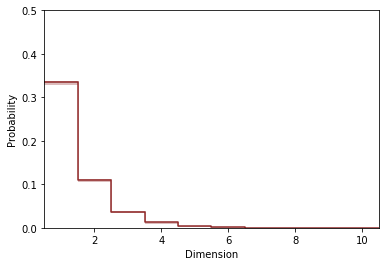

In [7]:
prob_means = [0] * len(Ds)
prob_ses = [0] * len(Ds)

for D in Ds:
  # Is the sampled point in the central interval?
  is_central_samples = [0] * N
  
  for n in range(N):
    # We start by assuming that the point will be
    # in the central interval
    is_central = 1
    
    # Sample a new point one dimension at a time
    for d in range(D):
      x_d = stats.uniform.rvs(-3, 3, size=1)
      
      # If the component of the point in the current
      # dimension is not contained within the central
      # interval then set the flag to false
      if -1 < x_d and x_d < 1:
        is_central = is_central & 1
      else:
        is_central = is_central & 0
    
    is_central_samples[n] = is_central
  
  # Estimate the relative volume as a probability
  s = compute_mc_stats(is_central_samples)
  prob_means[D - 1] = s[0]
  prob_ses[D - 1] = s[1]

# Plot probabilities verses dimension
plot.fill_between(plot_Ds, 
                  [ prob_means[idx] - 2 * prob_ses[idx] for idx in idxs ],
                  [ prob_means[idx] + 2 * prob_ses[idx] for idx in idxs ],
                  facecolor=light, color=light)
plot.plot(plot_Ds, [ prob_means[idx] for idx in idxs], color=dark)
  
plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 0.5])
plot.gca().set_ylabel("Probability")

plot.show()

### How much volume is in the neighborhood immediately outside a sphere, between a radius of 2 and 2.5, relative to the volume that lies in a neighborhood immediately inside that sphere, between a radius of 1.5 and 2?

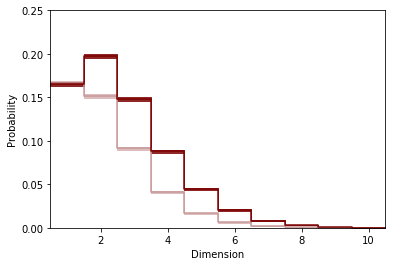

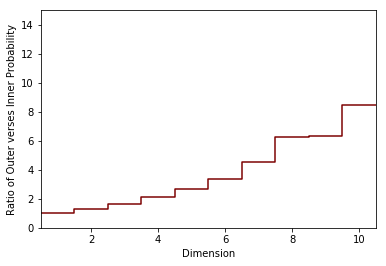

In [6]:
prob_inner_means = [0] * len(Ds)
prob_inner_ses = [0] * len(Ds)

prob_outer_means = [0] * len(Ds)
prob_outer_ses = [0] * len(Ds)

R = 2
delta = 0.5

for D in Ds:
  # Does the sampled point fall in the inside neighborhood?
  is_inner_samples = [0] * N
  # Does the sampled point fall in the outside neighborhood?
  is_outer_samples = [0] * N
  
  for n in range(N):
    # Sample a new point
    x = stats.uniform.rvs(-3, 3, size=D)
    
    # Compute distance from origin
    r = math.sqrt(sum([ x_d**2 for x_d in x]))
    
    # Check if point falls in the inside neighborhood
    if R - delta < r and r < R:
      is_inner_samples[n] = 1
    
    # Check if point falls in the outside neighborhood
    if R < r and r < R + delta:
      is_outer_samples[n] = 1;
  
  # Estimate the relative volumes as probabilies
  s1 = compute_mc_stats(is_inner_samples)
  prob_inner_means[D - 1] = s1[0]
  prob_inner_ses[D - 1] = s1[1]
  
  s2 = compute_mc_stats(is_outer_samples)
  prob_outer_means[D - 1] = s2[0]
  prob_outer_ses[D - 1] = s2[1]

# Plot probabilities verses dimension
plot.fill_between(plot_Ds, 
                  [ prob_inner_means[idx] - 2 * prob_inner_ses[idx] for idx in idxs ],
                  [ prob_inner_means[idx] + 2 * prob_inner_ses[idx] for idx in idxs ],
                  facecolor=light, color=light)
plot.plot(plot_Ds, [ prob_inner_means[idx] for idx in idxs], color=light_highlight)
  
plot.fill_between(plot_Ds, 
                  [ prob_outer_means[idx] - 2 * prob_outer_ses[idx] for idx in idxs ],
                  [ prob_outer_means[idx] + 2 * prob_outer_ses[idx] for idx in idxs ],
                  facecolor=dark, color=dark)
plot.plot(plot_Ds, [ prob_outer_means[idx] for idx in idxs], color=dark_highlight)

plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 0.25])
plot.gca().set_ylabel("Probability")

plot.show()

# Plot ratio of probabilities verses dimension
plot.plot(plot_Ds, 
          [ prob_outer_means[idx] / prob_inner_means[idx] for idx in idxs],
          color=dark_highlight)

plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 15])
plot.gca().set_ylabel("Ratio of Outer verses Inner Probability")

plot.show()

### How does the distance between two sampled points behave as the dimensionality of the box increases?

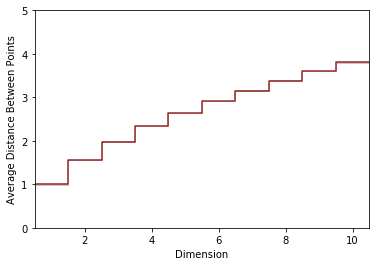

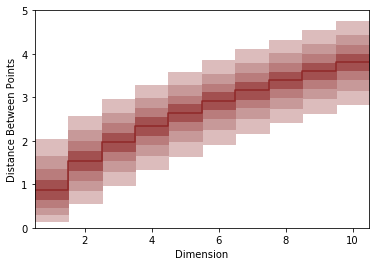

In [7]:
delta_means = [0] * len(Ds)
delta_ses = [0] * len(Ds)
delta_quantiles = [ [0] * 9 ] * len(Ds)

for D in Ds:
  # Distances between two sampled points
  delta_samples = [0] * N
  
  for n in range(N):
    # Sample two points
    x1 = stats.uniform.rvs(-3, 3, size=D)
    x2 = stats.uniform.rvs(-3, 3, size=D)
    
    # Compute distance between them
    delta_samples[n] = math.sqrt(sum([ (x1[d] - x2[d])**2 for d in range(D)]))
  
  # Estimate average distance
  s = compute_mc_stats(delta_samples)
  delta_means[D - 1] = s[0]
  delta_ses[D - 1] = s[1]
  
  # Estimate distance quantiles
  delta_quantiles[D - 1] = numpy.percentile(delta_samples, quant_probs)

# Plot average distance between points verses dimension
plot.fill_between(plot_Ds, 
                  [ delta_means[idx] - 2 * delta_ses[idx] for idx in idxs ],
                  [ delta_means[idx] + 2 * delta_ses[idx] for idx in idxs ],
                  facecolor=light, color=light)
plot.plot(plot_Ds, [ delta_means[idx] for idx in idxs], color=dark)

plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 5])
plot.gca().set_ylabel("Average Distance Between Points")

plot.show()

# Plot distance quantiles verses dimension
plot.fill_between(plot_Ds, 
                  [ delta_quantiles[idx][0] for idx in idxs ],
                  [ delta_quantiles[idx][8] for idx in idxs ],
                  facecolor=light, color=light)
plot.fill_between(plot_Ds, 
                  [ delta_quantiles[idx][1] for idx in idxs ],
                  [ delta_quantiles[idx][7] for idx in idxs ],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(plot_Ds, 
                  [ delta_quantiles[idx][2] for idx in idxs ],
                  [ delta_quantiles[idx][6] for idx in idxs ],
                  facecolor=mid, color=mid)
plot.fill_between(plot_Ds, 
                  [ delta_quantiles[idx][3] for idx in idxs ],
                  [ delta_quantiles[idx][5] for idx in idxs ],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(plot_Ds, [ delta_quantiles[idx][4] for idx in idxs ], color=dark)
                  
plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 5])
plot.gca().set_ylabel("Distance Between Points")

plot.show()

### How does the distance from a Gaussian sample and the Gaussian mode behave as the dimensionality increases?

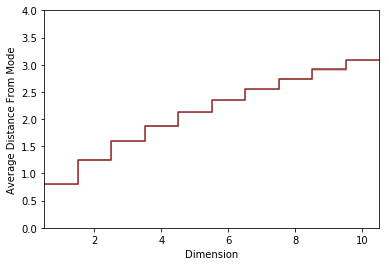

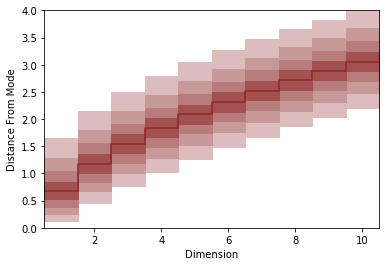

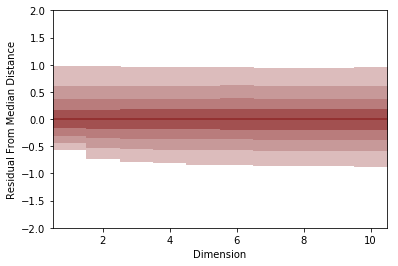

In [8]:
r_means = [0] * len(Ds)
r_ses = [0] * len(Ds)
r_quantiles = [ [0] * 9 ] * len(Ds)

for D in Ds: 
  # Distance from Gaussian samples to mode at zero
  r_samples = [0] * N
  
  for n in range(N):
    # Sample point
    x = stats.norm.rvs(0, 1, size=D)
    
    # Compute distance from point to mode at zero
    r_samples[n] = math.sqrt(sum([ x_d**2 for x_d in x]))
  
  # Estimate average distance
  s = compute_mc_stats(r_samples)
  r_means[D - 1] = s[0]
  r_ses[D - 1] = s[1]
  
  # Estimate distance quantiles
  r_quantiles[D - 1] = numpy.percentile(r_samples, quant_probs)

# Plot average distance from mode verses dimension
plot.fill_between(plot_Ds, 
                  [ r_means[idx] - 2 * r_ses[idx] for idx in idxs ],
                  [ r_means[idx] + 2 * r_ses[idx] for idx in idxs ],
                  facecolor=light, color=light)
plot.plot(plot_Ds, [ r_means[idx] for idx in idxs], color=dark)

plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 4])
plot.gca().set_ylabel("Average Distance From Mode")

plot.show()

# Plot distance quantiles verses dimension
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][0] for idx in idxs ],
                  [ r_quantiles[idx][8] for idx in idxs ],
                  facecolor=light, color=light)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][1] for idx in idxs ],
                  [ r_quantiles[idx][7] for idx in idxs ],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][2] for idx in idxs ],
                  [ r_quantiles[idx][6] for idx in idxs ],
                  facecolor=mid, color=mid)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][3] for idx in idxs ],
                  [ r_quantiles[idx][5] for idx in idxs ],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(plot_Ds, [ r_quantiles[idx][4] for idx in idxs ], color=dark)
                  
plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 4])
plot.gca().set_ylabel("Distance From Mode")

plot.show()

# Plot residual quantiles verses dimension
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][0] - r_quantiles[idx][4] for idx in idxs ],
                  [ r_quantiles[idx][8] - r_quantiles[idx][4] for idx in idxs ],
                  facecolor=light, color=light)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][1] - r_quantiles[idx][4] for idx in idxs ],
                  [ r_quantiles[idx][7] - r_quantiles[idx][4] for idx in idxs ],
                  facecolor=light_highlight, color=light_highlight)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][2] - r_quantiles[idx][4] for idx in idxs ],
                  [ r_quantiles[idx][6] - r_quantiles[idx][4] for idx in idxs ],
                  facecolor=mid, color=mid)
plot.fill_between(plot_Ds, 
                  [ r_quantiles[idx][3] - r_quantiles[idx][4] for idx in idxs ],
                  [ r_quantiles[idx][5] - r_quantiles[idx][4] for idx in idxs ],
                  facecolor=mid_highlight, color=mid_highlight)
plot.plot(plot_Ds, [ r_quantiles[idx][4] - r_quantiles[idx][4] for idx in idxs ], 
          color=dark)
                  
plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([-2, 2])
plot.gca().set_ylabel("Residual From Median Distance")

plot.show()

### What is the probability of a Gaussian sample falling into a spherical neighborhood around the mode at zero?

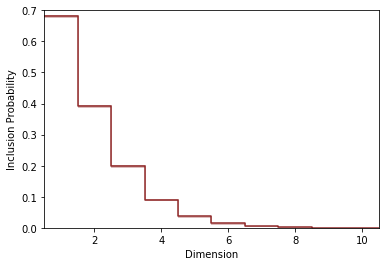

In [9]:
prob_means = [0] * len(Ds)
prob_ses = [0] * len(Ds)

R = 1

for D in Ds: 
  # Does the sample fall into the spherical neighborhood?
  is_central_samples = [0] * N
  
  for n in range(N):
    # Sample a new point
    x = stats.norm.rvs(0, 1, size=D)

    # Compute radial distance from mode
    r = math.sqrt(sum([ x_d**2 for x_d in x]))
    
    # Check if sample is contained within spherical neighborhood
    if r < R:
      is_central_samples[n] = 1
  
  # Estimate probability of falling into spherical neighborhood
  s = compute_mc_stats(is_central_samples)
  prob_means[D - 1] = s[0]
  prob_ses[D - 1] = s[1]

# Plot inclusion probability verses dimension
plot.fill_between(plot_Ds, 
                  [ prob_means[idx] - 2 * prob_ses[idx] for idx in idxs ],
                  [ prob_means[idx] + 2 * prob_ses[idx] for idx in idxs ],
                  facecolor=light, color=light)
plot.plot(plot_Ds, [ prob_means[idx] for idx in idxs], color=dark)

plot.gca().set_xlim([plot_Ds[0], plot_Ds[-1]])
plot.gca().set_xlabel("Dimension")
plot.gca().set_ylim([0, 0.7])
plot.gca().set_ylabel("Inclusion Probability")

plot.show()

# Done early?  Can you derive this probability analytically?
# Hint: convert to spherical coordinates and marginalize out
# the hyperspherical angles